In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import tskit as tsk
 
from bgspy.models import BGSModel
from bgspy.genome import Genome
from bgspy.utils import bin_chrom
from bgspy.data import GenomeData, pi_from_pairwise_summaries, trimmed_bins
from bgspy.sim_utils import mutate_simulated_tree
from bgspy.likelihood import FreeMutationModel
#from bgspy.sim_utils

2022-08-29 12:13:52.295448: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [30]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 200

In [3]:
g = Genome('hg38', seqlens_file="../data/annotation/hg38_seqlens.tsv", chroms=['chr10'])
#g.load_annot("../data/annotation/conserved_phastcons_thresh0.bed.gz")
#g.load_recmap("../data/annotation/hapmap_genetic_map.txt")

In [250]:
file = '../data/chrombgs_chr10_thresh0_N1000_mu3.16e-09_sh0.0316_chr10_seed1519291738_rep1_treeseq.tree'
file1 = '../data/chrombgs_chr10_thresh0_N10k_N10000_mu1e-08_sh0.01_chr10_seed3290190163_rep70_treeseq.tree'
file2 = '../data/chrombgs_chr10_thresh0_N10k_N10000_mu1e-08_sh0.01_chr10_seed3686382922_rep69_treeseq.tree'
file2 = '../data/chrombgs_chr10_merged_N1000_mu1e-08_sh0.01_chr10_seed3004617362_rep9_treeseq.tree'
file2 = '../data/chrombgs_chr10_merged_N1000_mu1e-08_sh0.01_chr10_seed2988394250_rep7_treeseq.tree'
ts = tsk.load(file2)

In [234]:
pkl_b_file= '../data/bmaps/bgspy/bmap_hg38_sims_10000step_chr10.pkl'
pkl_b_file= '../data/bmaps/bgspy/bmap_hg38_6x5grid_10000step_10kN_genomiconly.pkl'
m = BGSModel.load(pkl_b_file)

In [235]:
gd = GenomeData(g)
gd.load_neutral_masks('../data/annotation/neutral_phastcons_thresh0_slop1k_chr10.bed.gz')
gd.load_accessibile_masks('../data/annotation/no_centro.bed')

In [251]:
gd.load_counts_from_ts(mutate_simulated_tree(ts, rate=1e-7), chrom='chr10')

Load real genomic data for comparison (e.g. to see how sims compare).

In [237]:
hg38_gd = GenomeData(g)
hg38_gd.load_counts_dir('../data/h1kg/hg1k_counts/')
hg38_gd.load_neutral_masks('../data/annotation/neutral_phastcons_thresh0_slop1k_chr10.bed.gz')
hg38_gd.load_accessibile_masks('../data/annotation/no_centro.bed')

In [238]:
hg38_bins, hg38_pi = hg38_gd.bin_pi(width=1e6, filter_neutral=True, filter_accessible=True)

In [239]:
winsize = 1_000_000

_, pi = gd.bin_pi(winsize)
bins, Y = gd.bin_reduce(winsize, merge=True)
trim_bins, trim_Y, trim_idx = trimmed_bins(Y, bins, (0.0, 0.99))

In [240]:
Bo = np.concatenate([m.BScores.bin_means(bins).B[c] for c in bins.bins.keys()], axis=0)
Bpo = np.concatenate([m.BpScores.bin_means(bins).B[c] for c in bins.bins.keys()], axis=0)

B, Bp = Bo[trim_idx, :], Bpo[trim_idx, :]

(array([3400.84277235, 2834.03564362, 3967.64990107, 6234.87841597,
        8502.10693087, 6801.6855447 , 5668.07128725, 9635.72118832,
        3967.64990107, 3400.84277235, 1700.42138617, 2834.03564362,
        1700.42138617, 3400.84277235, 2834.03564362, 2267.2285149 ,
        2267.2285149 ,  566.80712872, 1700.42138617,  566.80712872]),
 array([7.16174512e-05, 8.50851502e-05, 9.85528492e-05, 1.12020548e-04,
        1.25488247e-04, 1.38955946e-04, 1.52423645e-04, 1.65891344e-04,
        1.79359043e-04, 1.92826742e-04, 2.06294441e-04, 2.19762140e-04,
        2.33229839e-04, 2.46697538e-04, 2.60165237e-04, 2.73632936e-04,
        2.87100635e-04, 3.00568334e-04, 3.14036033e-04, 3.27503732e-04,
        3.40971431e-04]),
 <BarContainer object of 20 artists>)

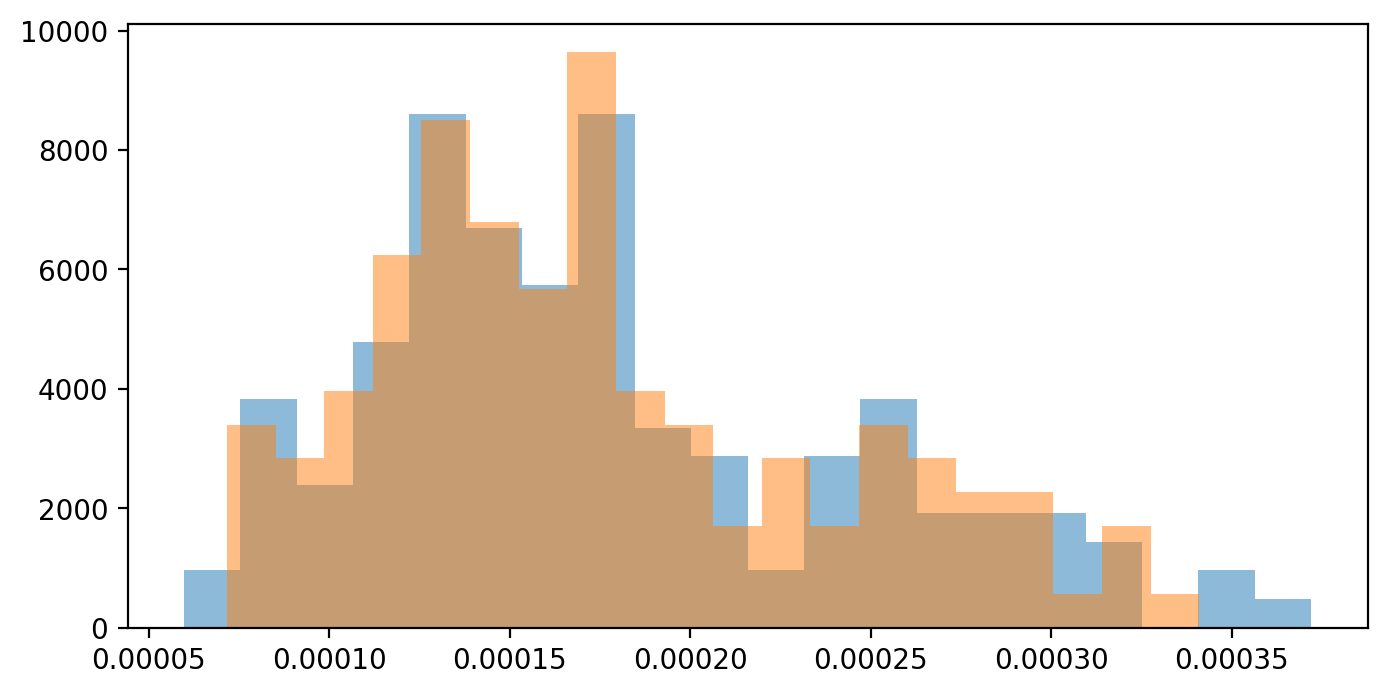

In [241]:
plt.hist(pi['chr10'].stat, 20, density=True, alpha=0.5)
plt.hist(pi_from_pairwise_summaries(trim_Y), 20, density=True, alpha=0.5)

In [242]:
ts_bins = bin_chrom(ts.sequence_length, winsize)
bm_pi = ts.diversity(mode='branch', windows=ts_bins)
ts_midpoints = (ts_bins[1:]+ts_bins[:-1])/2

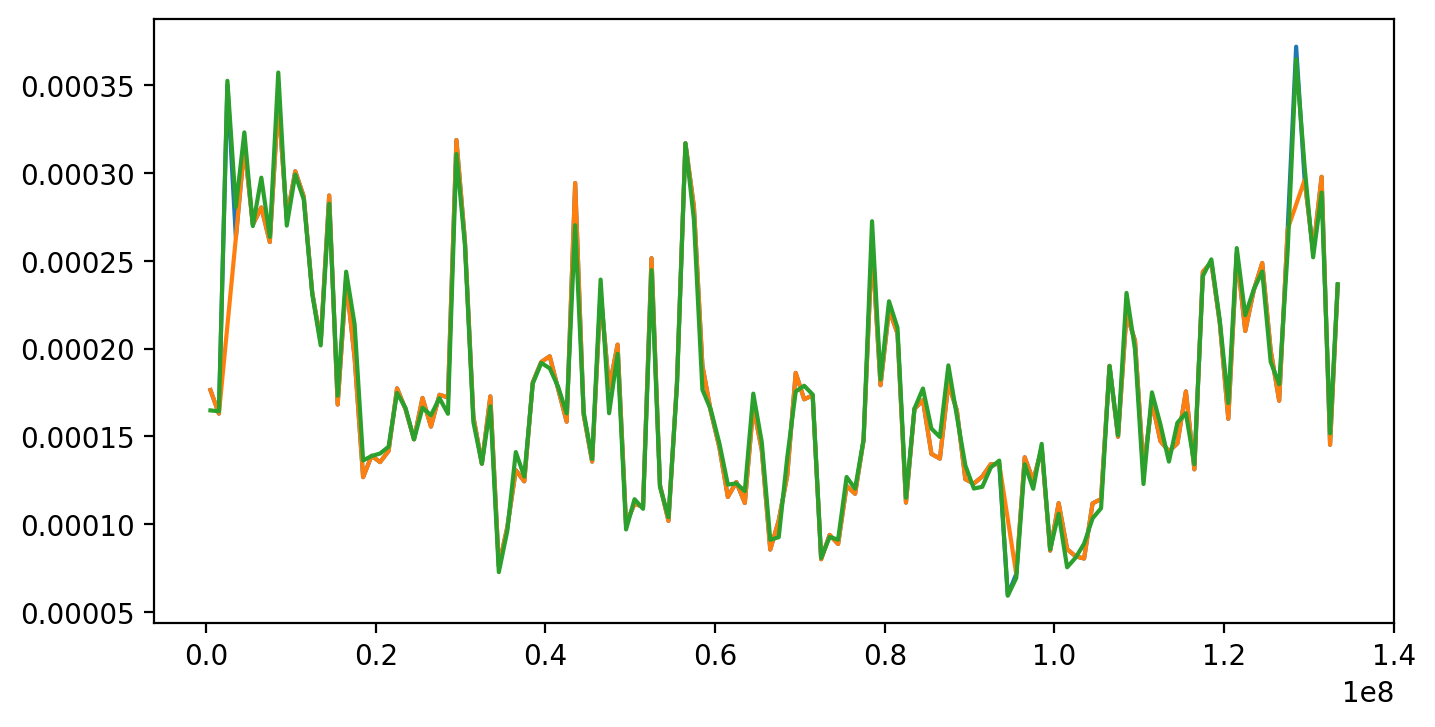

In [243]:
plt.plot(*pi['chr10'].pairs)

midpoints = [(s+e)/2 for c, s, e in trim_bins]
plt.plot(midpoints, pi_from_pairwise_summaries(trim_Y))

plt.plot(ts_midpoints, bm_pi * 1e-7)

In [244]:
m.t

array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01])

In [246]:
#np.random.seed(1)

#w, t = m.w, m.t
w = m.w
t = np.logspace(-4, -1, 4)
#lik_nml = FreeMutationModel(w, t, Bp[:, :, [0, 2, 4, 6], :], Y=trim_Y)
lik_nml = FreeMutationModel(m.w, m.t, Bp, Y=trim_Y)
lik_nml.fit(starts=10000, ncores=70, algo='NELDERMEAD')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [03:21<00:00, 49.68it/s]


In [247]:
lik_nml

MLE (interpolated w): 6 x 5 x 3
  w grid: [1.000e-11 6.310e-11 3.981e-10 2.512e-09 1.585e-08 1.000e-07] (before interpolation)
  t grid: [1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]

Free-mutation model ML estimates:
negative log-likelihood: 440711552629.5444
π0 = 0.00033724733346463616
W = 
----------  ----------  -----------
0.0011092   0.00172199  0.99697
0.00108322  0.00170173  0.000804621
0.00103627  0.00170163  0.000733218
0.851698    0.00170165  0.000762581
0.145073    0.993173    0.00073003
----------  ----------  -----------
μ = 
-----------  ----------  -----------
9.65001e-09  5.8767e-09  1.36981e-08
-----------  ----------  -----------

In [248]:
lik_nml.theta_

array([3.37247333e-04, 1.07037639e-11, 1.01196344e-11, 1.36565511e-08,
       1.04530881e-11, 1.00005404e-11, 1.10217457e-11, 1.00000000e-11,
       1.00000000e-11, 1.00436608e-11, 8.21889075e-09, 1.00000905e-11,
       1.04458825e-11, 1.39995884e-09, 5.83658092e-09, 1.00000000e-11])

Text(0.5, 1.0, '$R^2 = 0.83$')

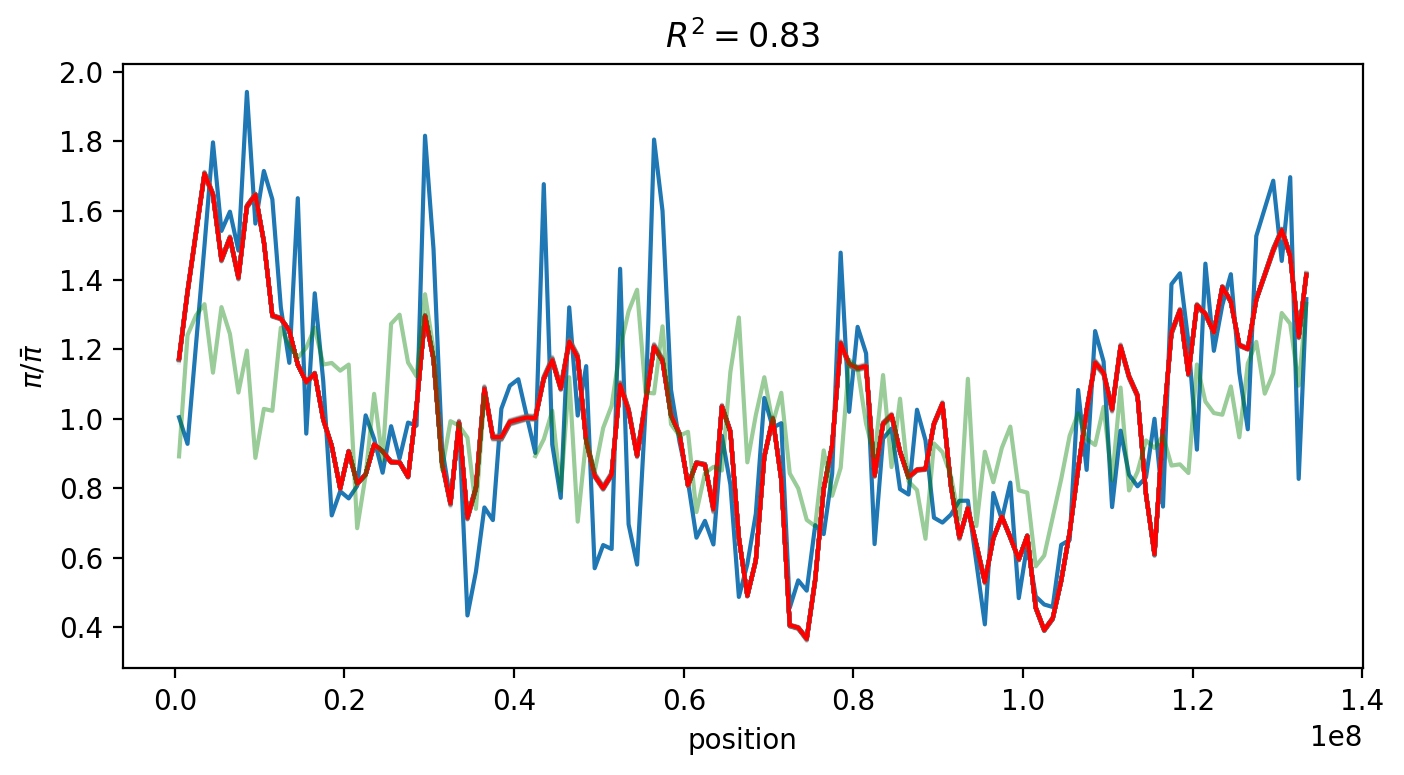

In [252]:
def ratio(x):
    return x/np.nanmean(x)


#plt.plot(ratio(pi['chr10'].pairs[1]))

midpoints = [(s+e)/2 for c, s, e in trim_bins]
#plt.scatter(midpoints, ratio(pi_from_pairwise_summaries(trim_Y)), s=5)
plt.plot(midpoints, ratio(pi_from_pairwise_summaries(trim_Y)))


for i in range(100):
    plt.plot(midpoints, ratio(lik_nml.predict(optim=i)), c='0.44', alpha=0.1)
    
plt.plot(midpoints, ratio(lik_nml.predict()), c='r')

hg38_x, hg38_y = hg38_pi['chr10'].pairs
plt.plot(hg38_x, ratio(hg38_y), c='g', alpha=0.4)
plt.ylabel("$\pi/\\bar{\pi}$")
plt.xlabel("position")
plt.title(f"$R^2 = {lik_nml.R2():.2}$")

In [ ]:
a = pi_from_pairwise_summaries(trim_Y) 
from bgspy.likelihood import R2
R2(np.repeat(lik_nml.predict().mean(), a.size), a)

In [ ]:
lik_nml.R2()

In [ ]:
lik_nml

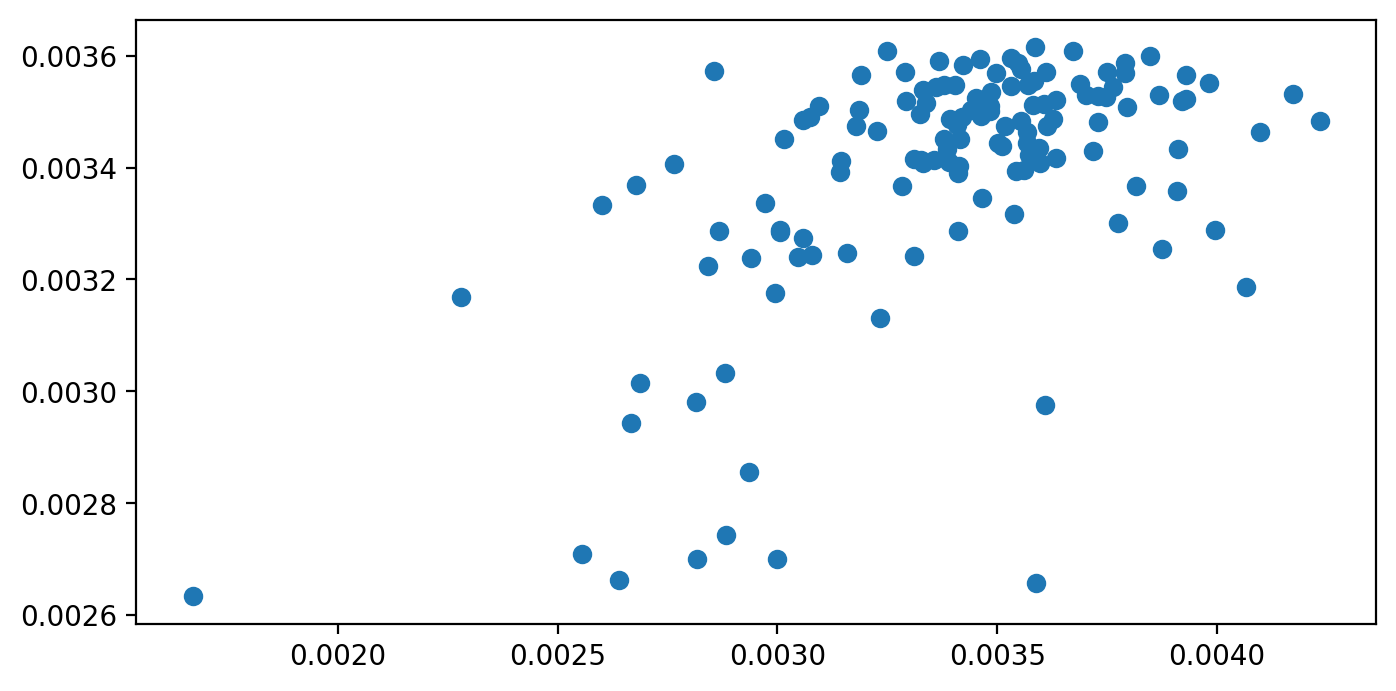

In [224]:
plt.scatter(pi_from_pairwise_summaries(trim_Y), lik_nml.predict())